<a href="https://colab.research.google.com/github/ashutosh17dec/dl/blob/master/trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
import keras
from keras.models import Model
#from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Reshape, Flatten, Lambda, Conv2DTranspose 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, Conv2DTranspose, Concatenate
import keras.backend as Kr
from keras.preprocessing import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.python.framework import ops
import math
#------------------------------------
from os import listdir
from os.path import isfile, join
import tensorflow_probability as tfp
import tensorflow.math
import cmath


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
from tensorflow.python.compat import compat
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import random_seed
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gen_image_ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.ops import variables
from tensorflow.python.util import deprecation
from tensorflow.python.util.tf_export import tf_export


In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = Kr.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root = '/content/gdrive/My Drive/Colab Notebooks/dlproject/racian/'

In [8]:
def read_images(image_type):
  folder_path = os.path.join(root, image_type)
  img_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
  conver_name = []
#   for j in img_names:
#     j=j[:-4]
#     j = int(j)
#     conver_name.append(j)
  print(len(img_names))
  img_list_phase = []
  img_list_mag =[]
  for i in range(1,len(img_names)+1):
    i = str('%05d'%i)+'.jpg'
    img_path = os.path.join(folder_path, i)
    if isfile(img_path):
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       img = cv2.resize(img, (256, 256))
       fix = np.fft.fft2(img)
       fshift = np.fft.fftshift(fix)
       imaginary = fshift.imag
       real = fshift.real
       [m,n] = fshift.shape
       phase = np.zeros([m,n],dtype=np.float)
       magnitude =np.abs(fshift)/np.amax(np.abs(fshift))
       magnitude = magnitude*255
       for i in range(m):
           for j in range(n):
              phase[i,j] = math.atan2(imaginary[i,j],real[i,j])
              if phase[i,j]<0:
                  phase[i,j] = 2*math.pi+phase[i,j]
              
       img_list_phase.append(phase)
       img_list_mag.append(magnitude)
  img_array_phase = np.array(img_list_phase)
  img_array_mag = np.array(img_list_mag)
  return img_array_mag,img_array_phase
  
def read_image(image_type):
  folder_path = os.path.join(root, image_type)
  img_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
  conver_name = []
#   for j in img_names:
#     j=j[:-4]
#     j = int(j)
#     conver_name.append(j)
  print(len(img_names))
  img_list_phase = []
  img_list_mag =[]
  img_list = []
  for i in range(1,len(img_names)+1):
    i = str('%05d'%i)+'.jpg'
    img_path = os.path.join(folder_path, i)
    if isfile(img_path):
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       img = cv2.resize(img, (256, 256))
       img_list.append(img)
  img_array = np.array(img_list)
  return img_array

GT_mag, GT_phase = read_images('GT')
artifact_mag, artifact_phase= read_images('input')
x_test_mag, x_test_phase= read_images('test')
 
# GT_img_array = read_image('GT')
# artifact_img_array= read_image('input')
# x_test= read_image('test')

1650
1650
150


(1650, 256, 256)
(1650, 256, 256)


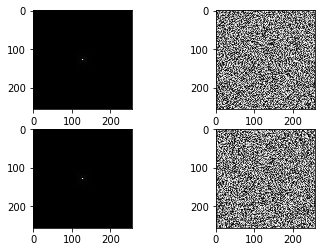

In [9]:
print(GT_phase.shape)
print(artifact_phase.shape)

plt.subplot(221)
plt.imshow(GT_mag[569,:,:], cmap='gray')
plt.subplot(223)
plt.imshow(artifact_mag[569,:,:], cmap='gray')
plt.subplot(222)
plt.imshow(GT_phase[569,:,:], cmap='gray')
plt.subplot(224)
plt.imshow(artifact_phase[569,:,:], cmap='gray')

In [25]:
y_train1 = GT_mag.astype('float32')/255
y_train1 = y_train1.reshape([-1,y_train1.shape[1], y_train1.shape[2],1])
x_train1 = artifact_mag.astype('float32')/255
x_train1 = x_train1.reshape([-1,x_train1.shape[1], x_train1.shape[2],1])
x_test1 = x_test_mag.astype('float32')/255
x_test1 = x_test1.reshape([-1,x_test1.shape[1], x_test1.shape[2],1])
print(x_train1.shape, y_train1.shape , x_test1.shape)
print(y_train1[560,:,:,:])
y_train2 = GT_phase.astype('float32')/(2*math.pi)
y_train2 = y_train2.reshape([-1,y_train2.shape[1], y_train2.shape[2],1])
x_train2 = artifact_phase.astype('float32')/(2*math.pi)
x_train2 = x_train2.reshape([-1,x_train2.shape[1], x_train2.shape[2],1])
x_test2 = x_test_phase.astype('float32')/(2*math.pi)
x_test2 = x_test2.reshape([-1,x_test2.shape[1], x_test2.shape[2],1])
print(x_train2.shape, y_train2.shape , x_test2.shape)
print(y_train2[560,:,:,:])

(1650, 256, 256, 1) (1650, 256, 256, 1) (150, 256, 256, 1)
[[[2.93470948e-05]
  [1.14023642e-05]
  [1.50856686e-05]
  ...
  [1.22597530e-05]
  [1.50856686e-05]
  [1.14023642e-05]]

 [[6.15617364e-06]
  [2.81152807e-05]
  [8.21692174e-06]
  ...
  [1.31076986e-05]
  [1.87471614e-05]
  [1.09343700e-05]]

 [[5.78235586e-06]
  [1.94592103e-05]
  [1.07587175e-05]
  ...
  [9.37520781e-06]
  [1.90728824e-05]
  [1.42253366e-05]]

 ...

 [[1.68921360e-05]
  [3.74928595e-06]
  [2.03340387e-05]
  ...
  [1.49149691e-05]
  [1.49807911e-05]
  [4.86298859e-06]]

 [[5.78235586e-06]
  [1.42253366e-05]
  [1.90728824e-05]
  ...
  [1.07706810e-05]
  [1.07587175e-05]
  [1.94592103e-05]]

 [[6.15617364e-06]
  [1.09343700e-05]
  [1.87471614e-05]
  ...
  [1.14023896e-05]
  [8.21692174e-06]
  [2.81152807e-05]]]
(1650, 256, 256, 1) (1650, 256, 256, 1) (150, 256, 256, 1)
[[[0.5       ]
  [0.63274896]
  [0.76603204]
  ...
  [0.65068   ]
  [0.23396793]
  [0.36725104]]

 [[0.9456917 ]
  [0.97553563]
  [0.54375523]
 

In [0]:
shape_x = x_train1.shape[1]
shape_y = x_train1.shape[2]
inputs = Input(shape=(shape_x, shape_y, 1))

In [0]:

  
  #down sampling 
  f = 8
  layers = []
  x = inputs
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  


In [14]:
autoencoder1 = Model(inputs, outputs)
print(autoencoder1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 8)  584         conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 

In [15]:
autoencoder2 = Model(inputs, outputs)
print(autoencoder2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 8)  584         conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 

In [0]:
def ssim_loss(y_true, y_pred):
    im1 = y_true
    im2 = y_pred
    # Compute SSIM over tf.uint8 Tensors.
    ssim1 = tf.image.ssim(im1, im2, max_val=255)

    # Compute SSIM over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    ssim2 = tf.image.ssim(im1, im2, max_val=1.0)
    ssimw=(1-ssim2)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
    return (ssimw)

In [0]:
def psnr_metric(y_true , y_pred):
  im1 = y_true
  im2 = y_pred
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr1 = tf.image.psnr(im1 , im2 ,1.0)
  return psnr1

In [0]:
def ssim_metric(y_true, y_pred):
    im1 = y_true
    im2 = y_pred
    # Compute SSIM over tf.uint8 Tensors.
    ssim1 = tf.image.ssim(im1, im2, max_val=255)

    # Compute SSIM over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    ssim2 = tf.image.ssim(im1, im2, max_val=1.0)
    return ssim2

In [0]:
def c_loss(y_true,y_pred):
    q1=0
    q2=1
    q3=0
    return Kr.mean(q2*keras.losses.categorical_crossentropy(y_true, y_pred)+q3*keras.losses.binary_crossentropy(y_true, y_pred)+q1*keras.losses.kullback_leibler_divergence(y_true, y_pred), axis=-1)
   

In [26]:
m = 30
n_epoch = 10
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy',metrics = [psnr_metric])
autoencoder1.fit(x_train1,y_train1, validation_split=0.1, epochs=n_epoch, batch_size=m)

Train on 1485 samples, validate on 165 samples
Epoch 1/10
1485/1485 [==============================] - 13s 9ms/step - loss: 0.0092 - psnr_metric: 45.3884 - mean_iou: 0.0000e+00 - val_loss: 0.0096 - val_psnr_metric: 45.1354 - val_mean_iou: 0.0000e+00
Epoch 2/10
1485/1485 [==============================] - 8s 6ms/step - loss: 0.0092 - psnr_metric: 45.3884 - mean_iou: 0.0000e+00 - val_loss: 0.0096 - val_psnr_metric: 45.1354 - val_mean_iou: 0.0000e+00
Epoch 3/10
1485/1485 [==============================] - 9s 6ms/step - loss: 0.0092 - psnr_metric: 45.3884 - mean_iou: 0.0000e+00 - val_loss: 0.0096 - val_psnr_metric: 45.1354 - val_mean_iou: 0.0000e+00
Epoch 4/10
1485/1485 [==============================] - 9s 6ms/step - loss: 0.0092 - psnr_metric: 45.3884 - mean_iou: 0.0000e+00 - val_loss: 0.0096 - val_psnr_metric: 45.1354 - val_mean_iou: 0.0000e+00
Epoch 5/10
1485/1485 [==============================] - 9s 6ms/step - loss: 0.0092 - psnr_metric: 45.3884 - mean_iou: 0.0000e+00 - val_loss: 0.0

In [29]:
m = 30
n_epoch = 10
autoencoder2.compile(optimizer='adam', loss='kullback_leibler_divergence',metrics = [psnr_metric])
autoencoder2.fit(x_train2,y_train2, validation_split=0.1, epochs=n_epoch, batch_size=m)

Train on 1485 samples, validate on 165 samples
Epoch 1/10
1485/1485 [==============================] - 18s 12ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 2/10
1485/1485 [==============================] - 9s 6ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 3/10
1485/1485 [==============================] - 9s 6ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 4/10
1485/1485 [==============================] - 9s 6ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 5/10
1485/1485 [==============================] - 9s 6ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 6/10
1485/1485 [==============================] - 8s 6ms/step - loss: 7.8089 - psnr_metric: 4.7700 - val_loss: 7.8089 - val_psnr_metric: 4.7701
Epoch 7/10
1485/1485 [=============================

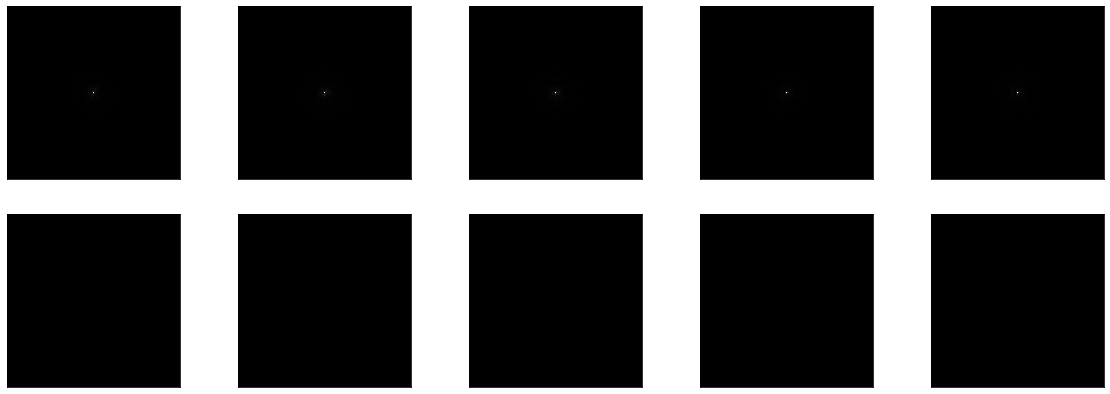

In [30]:
decoded_mag = autoencoder1.predict(x_test1)
n = 5
plt.figure(figsize=(20, 7))
for i in range(0,n):
    # display original noisy image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test1[i*20].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denosined image
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_mag[i*20].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

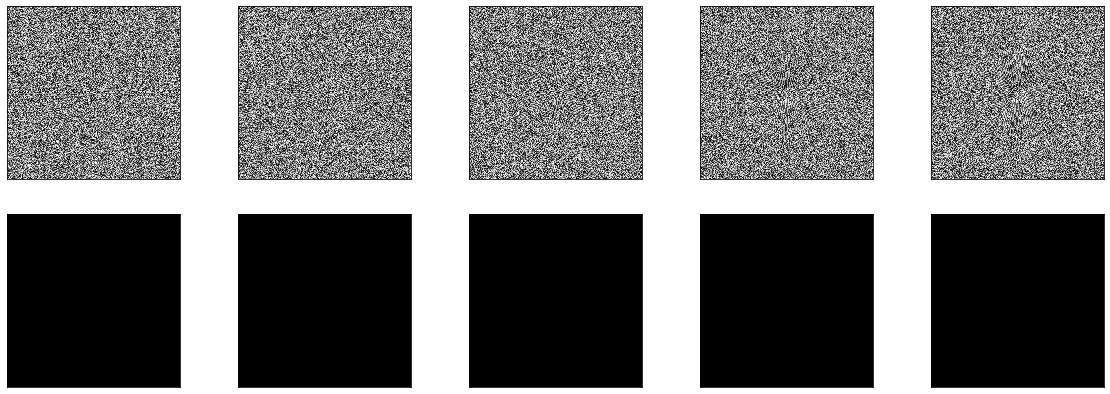

In [0]:
decoded_phase = autoencoder2.predict(x_test2)

n = 5
plt.figure(figsize=(20, 7))
for i in range(0,n):
    # display original noisy image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test2[i*20].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denosined image
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_phase[i*20].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

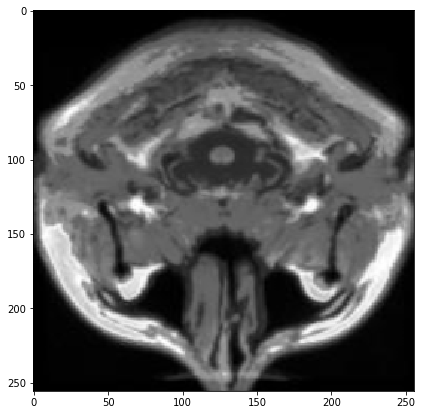

In [0]:
#recon
def recon(phase , mag):
  p = np.array(phase)
  m = np.array(mag)
  m = m/20
  [z,a] = p.shape
  
  img = np.zeros([z,a],dtype=np.complex)
  for i in range(z):
    for j in range(int(a)):
      m[i,j] = np.exp(m[i,j])     
      img[i,j] = m[i,j]*cmath.exp(1j*p[i,j])
  return img
o = 1500
fret = GT_phase[o,:,:].reshape(256,256)
crow = GT_mag[o,:,:].reshape(256,256)
imgre = recon(fret , crow)
f_ishift = np.fft.ifftshift(imgre)
img_back = np.fft.ifft2(imgre)
img_back = np.abs(img_back)
plt.figure(figsize=(20, 7))
plt.subplot(1,2,1)
plt.imshow(img_back.reshape(256,256),'gray')


0.7181639
0.8578105
0.8317563
0.8794268
0.9449239


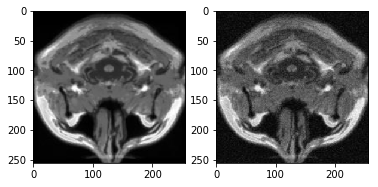

In [0]:
t =1500
im1 = y_train[t]
plt.subplot(1,2,1)
plt.imshow(im1.reshape(256,256),'gray')

im2 = x_train[t]
plt.subplot(1,2,2)
plt.imshow(im2.reshape(256,256),'gray')
iw1 = tf.convert_to_tensor(im1, dtype=tf.float32)
iw2 = tf.convert_to_tensor(im2, dtype=tf.float32)
st =ssim_structure_loss(iw1 , iw2)
sw =ssim_metric(iw1 , iw2)
ssim1,lum,cs,sst,cct = ssim_structure_trial(iw1 , iw2)
sess = tf.Session()
with sess.as_default():
    ssim1 = ssim1.eval()
    print (ssim1)
    lum = lum.eval()
    print (lum)
    cs = cs.eval()
    print (cs)
    sst = sst.eval()
    print (sst)
    cct = cct.eval()
    print (cct)
std_1  = np.std(im1)
std_2  = np.std(im2)
c = .03*255/2
X = np.reshape(im1,[-1])
Y = np.reshape(im2,[-1])
d = np.mean(X)
v = np.mean(Y)
su = 0
for i in range(0, X.shape[0]):
  su = su + (X[i]-d)*(Y[i]-v)
voc = su/(X.shape[0]-1)
ss = (voc + c)/(std_1*std_2 + c)
ss = ss**1


In [0]:
_SSIM_K1 = 0.01
_SSIM_K2 = 0.03
def _ssim_help(x, y, reducer, max_val, compensation=1.0):
  r"""Helper function for computing SSIM.
  SSIM estimates covariances with weighted sums.  The default parameters
  use a biased estimate of the covariance:
  Suppose `reducer` is a weighted sum, then the mean estimators are
    \mu_x = \sum_i w_i x_i,
    \mu_y = \sum_i w_i y_i,
  where w_i's are the weighted-sum weights, and covariance estimator is
    cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
  with assumption \sum_i w_i = 1. This covariance estimator is biased, since
    E[cov_{xy}] = (1 - \sum_i w_i ^ 2) Cov(X, Y).
  For SSIM measure with unbiased covariance estimators, pass as `compensation`
  argument (1 - \sum_i w_i ^ 2).
  Arguments:
    x: First set of images.
    y: Second set of images.
    reducer: Function that computes 'local' averages from set of images.
      For non-covolutional version, this is usually tf.reduce_mean(x, [1, 2]),
      and for convolutional version, this is usually tf.nn.avg_pool or
      tf.nn.conv2d with weighted-sum kernel.
    max_val: The dynamic range (i.e., the difference between the maximum
      possible allowed value and the minimum allowed value).
    compensation: Compensation factor. See above.
  Returns:
    A pair containing the luminance measure, and the contrast-structure measure.
  """
  c1 = (_SSIM_K1 * max_val) ** 2
  c2 = (_SSIM_K2 * max_val) ** 2

  # SSIM luminance measure is
  # (2 * mu_x * mu_y + c1) / (mu_x ** 2 + mu_y ** 2 + c1).
  mean0 = reducer(x)
  mean1 = reducer(y)
  num0 = mean0 * mean1 * 2.0
  den0 = math_ops.square(mean0) + math_ops.square(mean1)
  luminance = (num0 + c1) / (den0 + c1)

  # SSIM contrast-structure measure is
  #   (2 * cov_{xy} + c2) / (cov_{xx} + cov_{yy} + c2).
  # Note that `reducer` is a weighted sum with weight w_k, \sum_i w_i = 1, then
  #   cov_{xy} = \sum_i w_i (x_i - \mu_x) (y_i - \mu_y)
  #          = \sum_i w_i x_i y_i - (\sum_i w_i x_i) (\sum_j w_j y_j).
  num1 = reducer(x * y) * 2.0
  den1 = reducer(math_ops.square(x) + math_ops.square(y))
  gre1 = reducer(x**2)
  gre2 = reducer(y**2)
  den1_1 = tf.math.sqrt(abs((gre1-reducer(x)**2)*(gre2-reducer(y)**2)))
  den11 = tf.math.sqrt(mean1**2)
  c2 *= compensation
  cs = (num1 - num0 + c2) / (den1 - den0 + c2)
  structure =(num1 - num0 + c2) / (2*den1_1 + c2)
  cont = (2*den1_1 + c2) / (den1 - den0 + c2)
  # SSIM score is the product of the luminance and contrast-structure measures.
  return luminance, cs ,structure ,cont


def _fspecial_gaussian(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  size = ops.convert_to_tensor(size, dtypes.int32)
  sigma = ops.convert_to_tensor(sigma)

  coords = math_ops.cast(math_ops.range(size), sigma.dtype)
  coords -= math_ops.cast(size - 1, sigma.dtype) / 2.0

  g = math_ops.square(coords)
  g *= -0.5 / math_ops.square(sigma)

  g = array_ops.reshape(g, shape=[1, -1]) + array_ops.reshape(g, shape=[-1, 1])
  g = array_ops.reshape(g, shape=[1, -1])  # For tf.nn.softmax().
  g = nn_ops.softmax(g)
  return array_ops.reshape(g, shape=[size, size, 1, 1])


def _ssim_per_channel1(img1, img2, max_val=1.0):
  """Computes SSIM index between img1 and img2 per color channel.
  This function matches the standard SSIM implementation from:
  Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image
  quality assessment: from error visibility to structural similarity. IEEE
  transactions on image processing.
  Details:
    - 11x11 Gaussian filter of width 1.5 is used.
    - k1 = 0.01, k2 = 0.03 as in the original paper.
  Args:
    img1: First image batch.
    img2: Second image batch.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
  Returns:
    A pair of tensors containing and channel-wise SSIM and contrast-structure
    values. The shape is [..., channels].
  """
  filter_size = constant_op.constant(11, dtype=dtypes.int32)
  filter_sigma = constant_op.constant(1.5, dtype=img1.dtype)

  shape1, shape2 = array_ops.shape_n([img1, img2])
  checks = [
      control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
          shape1[-3:-1], filter_size)), [shape1, filter_size], summarize=8),
      control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(
          shape2[-3:-1], filter_size)), [shape2, filter_size], summarize=8)]

  # Enforce the check to run before computation.
  with ops.control_dependencies(checks):
    img1 = array_ops.identity(img1)

  # TODO(sjhwang): Try to cache kernels and compensation factor.
  kernel = _fspecial_gaussian(filter_size, filter_sigma)
  kernel = array_ops.tile(kernel, multiples=[1, 1, shape1[-1], 1])

  # The correct compensation factor is `1.0 - tf.reduce_sum(tf.square(kernel))`,
  # but to match MATLAB implementation of MS-SSIM, we use 1.0 instead.
  compensation = 1.0

  # TODO(sjhwang): Try FFT.
  # TODO(sjhwang): Gaussian kernel is separable in space. Consider applying
  #   1-by-n and n-by-1 Gaussain filters instead of an n-by-n filter.
  def reducer(x):
    shape = array_ops.shape(x)
    x = array_ops.reshape(x, shape=array_ops.concat([[-1], shape[-3:]], 0))
    y = nn.depthwise_conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID')
    return array_ops.reshape(y, array_ops.concat([shape[:-3],
                                                  array_ops.shape(y)[1:]], 0))

  luminance, cs ,sst ,cct = _ssim_help(img1, img2, reducer, max_val, compensation)

  # Average over the second and the third from the last: height, width.
  axes = constant_op.constant([-3, -2], dtype=dtypes.int32)
  ssim_val = math_ops.reduce_mean(cs*luminance, axes)
  lum =math_ops.reduce_mean(luminance, axes)
  sst = math_ops.reduce_mean(sst, axes)
  cct = math_ops.reduce_mean(cct, axes)
  cs = math_ops.reduce_mean(cs, axes)
  return ssim_val,lum, cs , sst , cct


@tf_export('image.ssim')
def ssim_test(img1, img2, max_val):
  """Computes SSIM index between img1 and img2.
  This function is based on the standard SSIM implementation from:
  Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image
  quality assessment: from error visibility to structural similarity. IEEE
  transactions on image processing.
  Note: The true SSIM is only defined on grayscale.  This function does not
  perform any colorspace transform.  (If input is already YUV, then it will
  compute YUV SSIM average.)
  Details:
    - 11x11 Gaussian filter of width 1.5 is used.
    - k1 = 0.01, k2 = 0.03 as in the original paper.
  The image sizes must be at least 11x11 because of the filter size.
  Example:
  ```python
      # Read images from file.
      im1 = tf.decode_png('path/to/im1.png')
      im2 = tf.decode_png('path/to/im2.png')
      # Compute SSIM over tf.uint8 Tensors.
      ssim1 = tf.image.ssim(im1, im2, max_val=255)
      # Compute SSIM over tf.float32 Tensors.
      im1 = tf.image.convert_image_dtype(im1, tf.float32)
      im2 = tf.image.convert_image_dtype(im2, tf.float32)
      ssim2 = tf.image.ssim(im1, im2, max_val=1.0)
      # ssim1 and ssim2 both have type tf.float32 and are almost equal.
  ```
  Args:
    img1: First image batch.
    img2: Second image batch.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
  Returns:
    A tensor containing an SSIM value for each image in batch.  Returned SSIM
    values are in range (-1, 1], when pixel values are non-negative. Returns
    a tensor with shape: broadcast(img1.shape[:-3], img2.shape[:-3]).
  """
#   _, _, checks = tf.image._verify_compatible_image_shapes(img1, img2)
#   with ops.control_dependencies(checks):
#     img1 = array_ops.identity(img1)

  # Need to convert the images to float32.  Scale max_val accordingly so that
  # SSIM is computed correctly.
  max_val = math_ops.cast(max_val, img1.dtype)
  max_val = tf.image.convert_image_dtype(max_val, dtypes.float32)
  img1 = tf.image.convert_image_dtype(img1, dtypes.float32)
  img2 = tf.image.convert_image_dtype(img2, dtypes.float32)
  ssim_per_channel,lum, cs ,sst ,cct = _ssim_per_channel1(img1, img2, max_val)
  # Compute average over color channels.
  ssim1 =  math_ops.reduce_mean(ssim_per_channel, [-1])
  lum = math_ops.reduce_mean(lum, [-1])
  cs = math_ops.reduce_mean(cs, [-1])
  sst = math_ops.reduce_mean(sst, [-1])
  cct = math_ops.reduce_mean(cct, [-1])
  return ssim1 ,lum, cs , sst ,cct

In [0]:
def ssim_structure_trial(y_true, y_pred):
    im1 = y_true
    im2 = y_pred
    # Compute SSIM over tf.uint8 Tensors.
    ssim1 = tf.image.ssim(im1, im2, max_val=255)

    # Compute SSIM over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    ssim2,lum,cs,sst,cct = ssim_test(im1, im2, max_val=1.0)
    return ssim2,lum,cs,sst,cct